# imports


In [91]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
import xgboost as xgb
import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgbm

import shap

from matplotlib import pyplot as plt

pd.options.display.max_columns = 250

# read data

In [84]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [85]:
train.head()

id      f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
0   0 -1.373246  0.238887 -0.243376  0.567405 -0.647715  0.839326  0.113133   
1   1  1.697021 -1.710322 -2.230332 -0.545661  1.113173 -1.552175  0.447825   
2   2  1.681726  0.616746 -1.027689  0.810492 -0.609086  0.113965 -0.708660   
3   3 -0.118172 -0.587835 -0.804638  2.086822  0.371005 -0.128831 -0.282575   
4   4  1.148481 -0.176567 -0.664871 -1.101343  0.467875  0.500117  0.407515   

   f_07  f_08  f_09  f_10  f_11  f_12  f_13  f_14  f_15  f_16  f_17  f_18  \
0     1     5     1     3     3     3     1     6     1     0     7     4   
1     1     3     4     0     2     3     0     1     0     4     6     0   
2     1     0     2     6     6     4     3     1     2     2     1     4   
3     3     2     1     0     1     6     4     2     3     3     0     3   
4     3     3     0     4     3     0     6     0     3     3     1     0   

       f_19      f_20      f_21      f_22      f_23      f_24      f_25  \
0  0.298218 -0.919717  3.058541 -2.540739  0.766952 -2.730628 -0.208177   
1 -3.147667 -1.075434  2.179050  2.278315 -0.633658 -1.217077 -3.782194   
2  2.820733 -3.485342 -0.784235 -1.385775 -0.520558 -0.009121  2.788536   
3  1.081084 -2.100177 -2.343819  0.572594 -1.653213  1.686035 -2.533098   
4 -0.126179  0.605033  1.133665 -3.912929 -1.430366  2.127649 -3.306784   

       f_26        f_27        f_28  f_29  f_30  target  
0  1.363402  ABABDADBAB   67.609153     0     0       0  
1 -0.058316  ACACCADCEB  377.096415     0     0       1  
2 -3.703488  AAAEABCKAD -195.599702     0     2       1  
3 -0.608601  BDBBAACBCB  210.826205     0     0       1  
4  4.371371  BDBCBBCHFE -217.211798     0     1       1

In [86]:
test.head()

id      f_00      f_01      f_02      f_03      f_04      f_05  \
0  900000  0.442517  0.174380 -0.999816  0.762741  0.186778 -1.074775   
1  900001 -0.605598 -0.305715  0.627667 -0.578898 -1.750931  1.355550   
2  900002  0.303990  2.445110  0.246515  0.818248  0.359731 -1.331845   
3  900003  0.154053  0.260126 -1.367092 -0.093175 -1.111034 -0.948481   
4  900004 -1.651904 -0.424266 -0.667356 -0.322124 -0.089462  0.181705   

       f_06  f_07  f_08  f_09  f_10  f_11  f_12  f_13  f_14  f_15  f_16  f_17  \
0  0.501888     6     6     0     0     0     5     1     1     2     2     0   
1 -0.190911     1     3     4     0     2     1     3     0     0     0     2   
2  1.358622     3     3     4     1     1     3     2     2     4     1     0   
3  1.119220     0     0     4     2     1     5     0     3     3     1     4   
4  1.784983     2     2     2     0     0     3     0     1     2     0     2   

   f_18      f_19      f_20      f_21      f_22      f_23      f_24      f_25  \
0     1 -1.128371  2.749347 -1.006400 -1.193879 -2.435736 -2.427430 -1.966887   
1     0 -4.424098  1.080762  2.382405  0.149442  1.883322 -2.848714 -0.725155   
2     3 -1.523864 -1.406712 -7.026098  1.312277 -5.157192  1.714005  0.585032   
3     2 -1.404597  3.011085 -0.594532 -3.939475  1.754570 -2.364007 -1.003320   
4     2 -1.968516  0.100594  0.084906 -0.985736 -0.130467 -3.557893  1.210687   

       f_26        f_27        f_28  f_29  f_30  
0  5.734205  BAAABADLAC   99.478419     0     0  
1  3.194219  AFABBAEGCB  -65.993825     1     0  
2  0.066898  BBACABBKEE  -87.405622     0     1  
3  3.893099  AEBEAACQCC -281.293460     0     0  
4  1.861884  AEBBBBDABF   25.629415     0     2

In [87]:
train.shape, test.shape

((900000, 33), (700000, 32))

<AxesSubplot:>

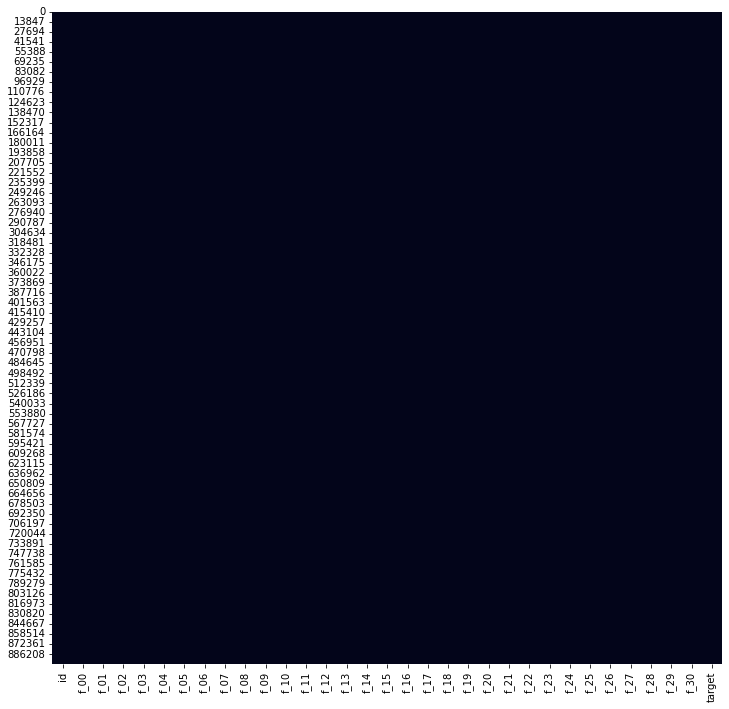

In [88]:
plt.figure(figsize=(12, 12))
sns.heatmap(train.isnull(), cbar=False)

<AxesSubplot:>

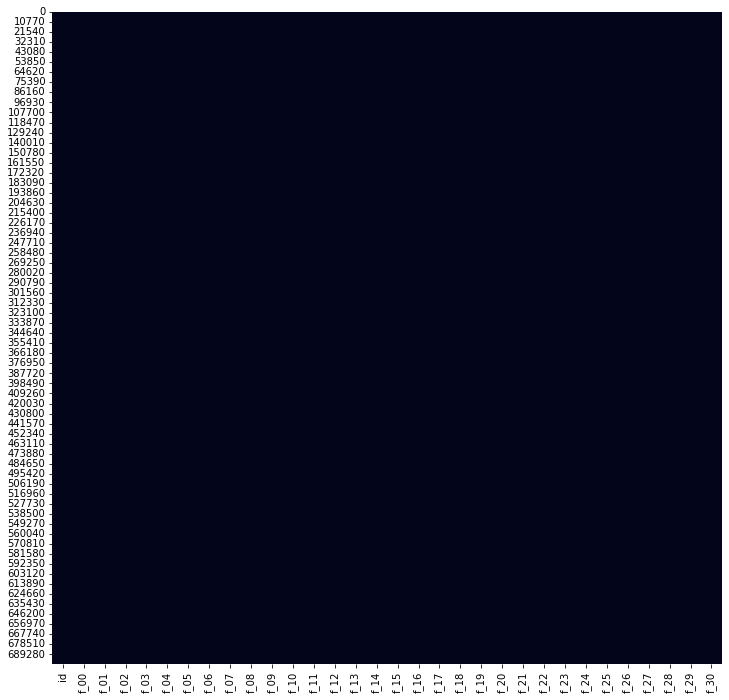

In [89]:
plt.figure(figsize=(12, 12))
sns.heatmap(test.isnull(), cbar=False)

# EDA

## floats

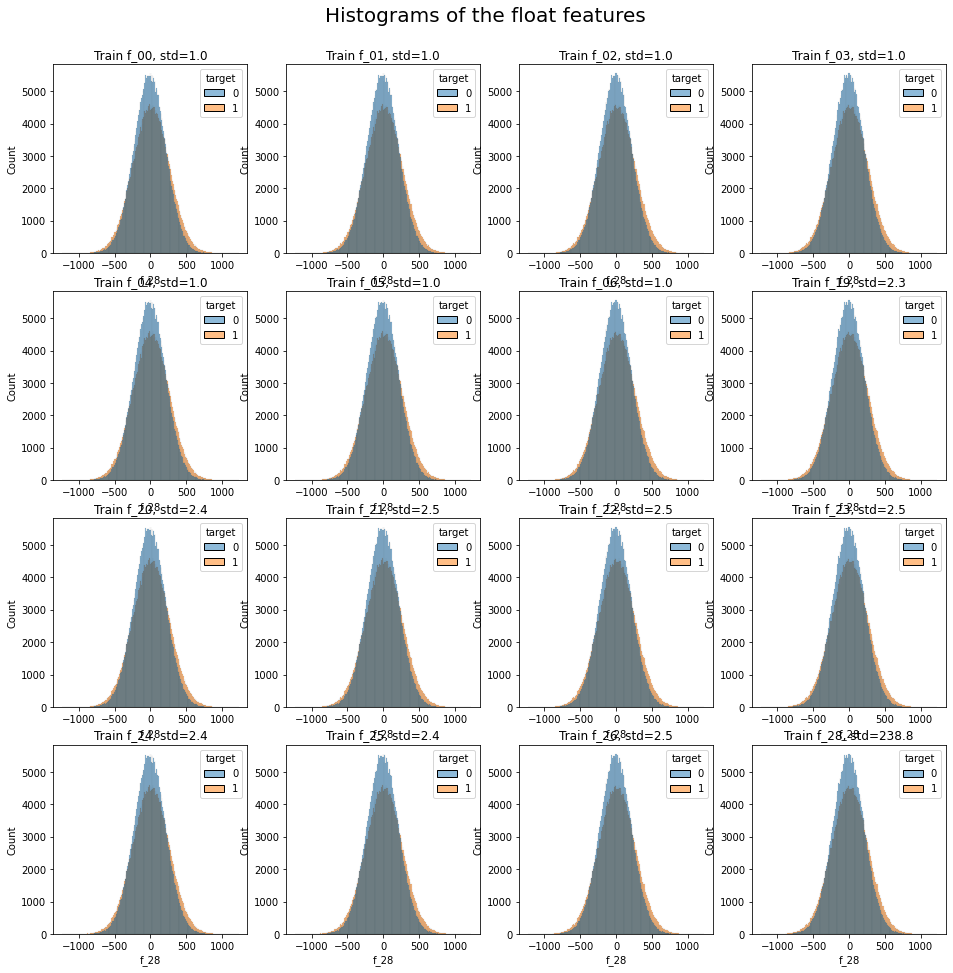

In [32]:
float_columns = ['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06',
                 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_28'
                ]
#for col in float_columns:
#    fig, ax = plt.subplots(figsize=(20,7))
#    
#    plt.title(col, fontsize=20)
    
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for f, ax in zip(float_columns, axs.ravel()):
    sns.histplot(data=train, x=col, hue='target', ax=ax)
    ax.set_title(f'Train {f}, std={train[f].std():.1f}')
plt.suptitle('Histograms of the float features', y=0.93, fontsize=20)
plt.show()

## correlations

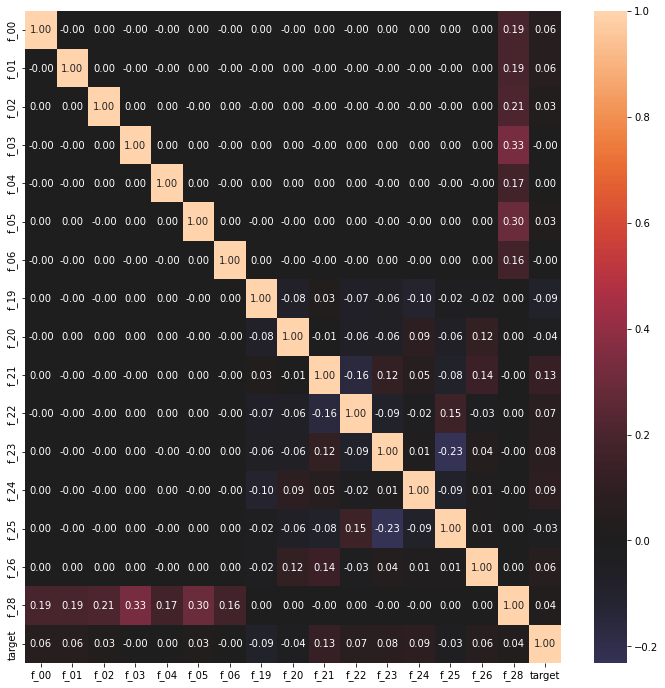

In [24]:
plt.figure(figsize=(12, 12))
sns.heatmap(train[float_columns + ['target']].corr(), center=0, annot=True, fmt='.2f')
plt.show()

## mutual information

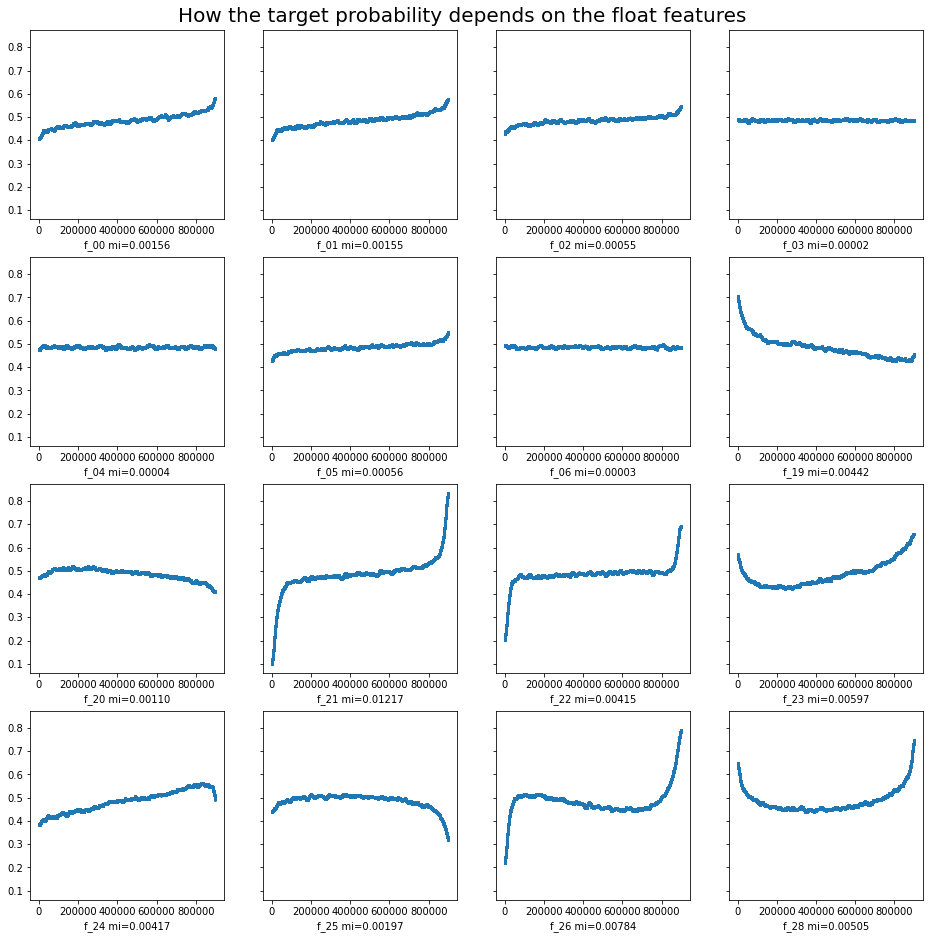

In [26]:
# Plot dependence between every feature and the target
def plot_mutual_info_diagram(df, features, ncols=4, by_quantile=True, mutual_info=True,
                             title='How the target probability depends on single features'):
    def H(p):
        """Entropy of a binary random variable in nat"""
        return -np.log(p) * p - np.log(1-p) * (1-p)
                 
    nrows = (len(features) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows*4), sharey=True)
    for f, ax in zip(features, axs.ravel()):
        temp = pd.DataFrame({f: df[f].values,
                             'state': df.target.values})
        temp = temp.sort_values(f)
        temp.reset_index(inplace=True)
        rolling_mean = temp.state.rolling(15000, center=True, min_periods=1).mean()
        if by_quantile:
            ax.scatter(temp.index, rolling_mean, s=2)
        else:
            ax.scatter(temp[f], rolling_mean, s=2)
        if mutual_info and by_quantile:
            ax.set_xlabel(f'{f} mi={H(temp.state.mean()) - H(rolling_mean[~rolling_mean.isna()].values).mean():.5f}')
        else:
            ax.set_xlabel(f'{f}')
    plt.suptitle(title, y=0.90, fontsize=20)
    plt.show()

plot_mutual_info_diagram(train, float_columns,
                         title='How the target probability depends on the float features')

## int features

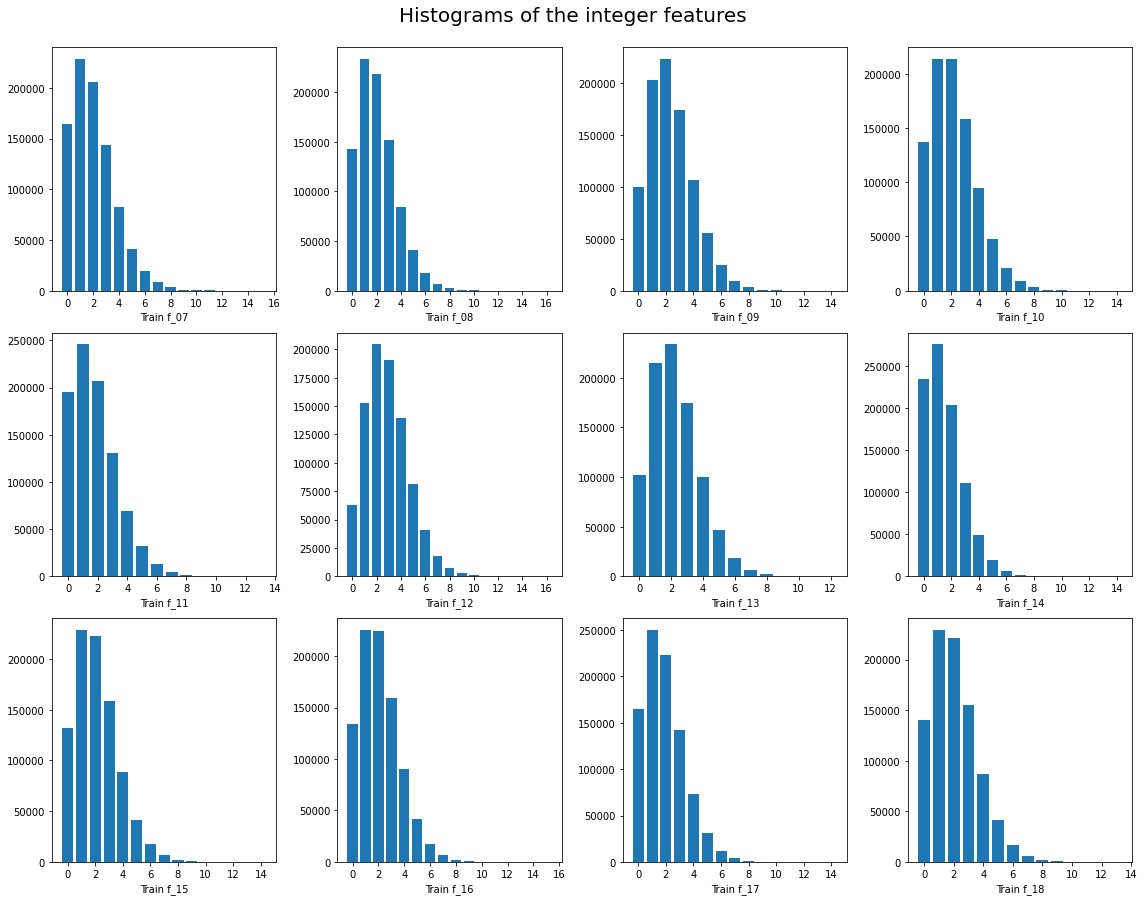

In [29]:
from matplotlib.ticker import MaxNLocator
int_columns = ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18']
figure = plt.figure(figsize=(16, 16))
for i, f in enumerate(int_columns):
    plt.subplot(4, 4, i+1)
    ax = plt.gca()
    vc = train[f].value_counts()
    ax.bar(vc.index, vc)
    #ax.hist(train[f], density=False, bins=(train[f].max()-train[f].min()+1))
    ax.set_xlabel(f'Train {f}')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
plt.suptitle('Histograms of the integer features', y=1.0, fontsize=20)
figure.tight_layout(h_pad=1.0)
plt.show()

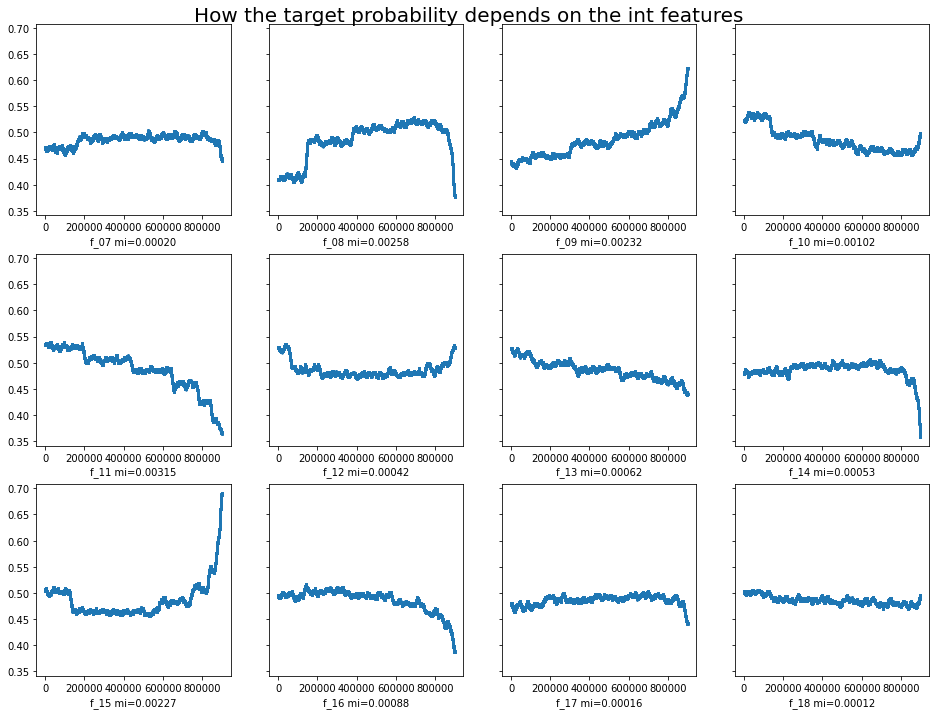

In [30]:
plot_mutual_info_diagram(train, int_columns,
                         title='How the target probability depends on the int features')

# feature engineering f_27

In [48]:
train['f_27'].value_counts()

BBBBBBCJBC    12
BCBBBBCLBC    12
BBBBBBDPCB    10
BBBBBBDKBC    10
ADBBBACQBC    10
              ..
BFAFAADTCE     1
BBBDAACOAE     1
BBABAACGBB     1
BFAABAGSDB     1
BCAACADSCE     1
Name: f_27, Length: 741354, dtype: int64

In [90]:
test['f_27'].value_counts()

BCBCBBCTBC    9
BBBBBABGCC    9
ABACBACHAA    8
BBBBBADGCC    8
BBBBBACDCC    8
             ..
BBBABBCGEC    1
BEBACABJDD    1
BDACEABBDD    1
BCABCBHKBC    1
BCBBCABNDE    1
Name: f_27, Length: 598482, dtype: int64

In [49]:
train['f_27'].nunique()

741354

In [50]:
train['f_27'].str.len().min(), train['f_27'].str.len().max()

(10, 10)

In [58]:
train['char_unique_num'] = train['f_27'].apply(set).apply(len)
test['char_unique_num'] = test['f_27'].apply(set).apply(len)

Text(0.5, 1.0, 'char_unique_num')

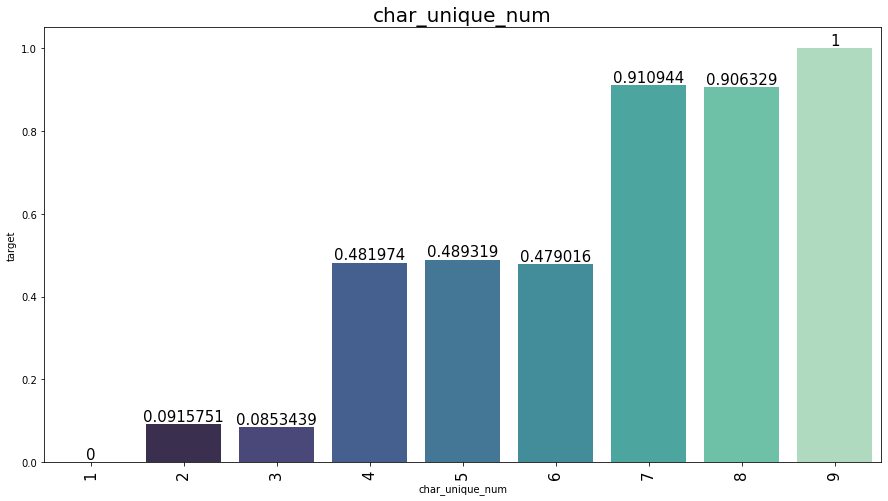

In [63]:
stats = train.groupby('char_unique_num', as_index=False)['target'].mean()

fig, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data=stats, ax=ax, x="char_unique_num", y="target",  palette="mako",ci=None)
plt.xticks(rotation=90, fontsize=15) 
ax.bar_label(ax.containers[0], fontsize=15)
plt.title("char_unique_num", fontsize=20)

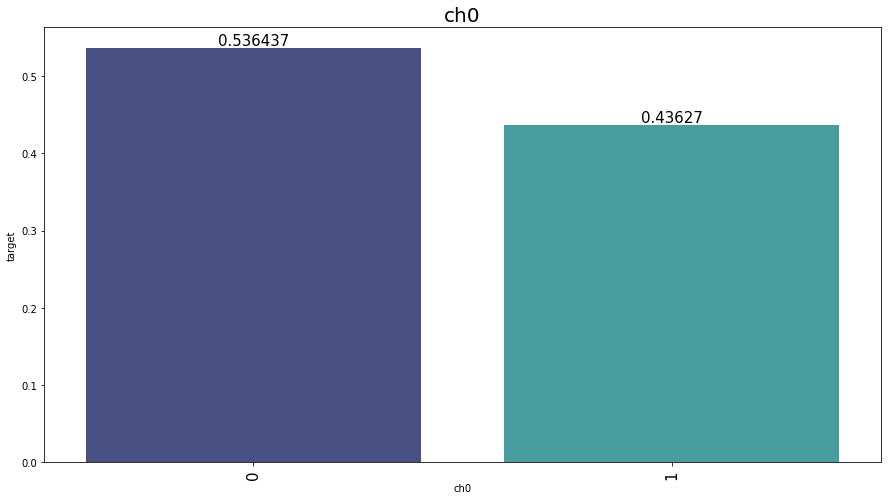

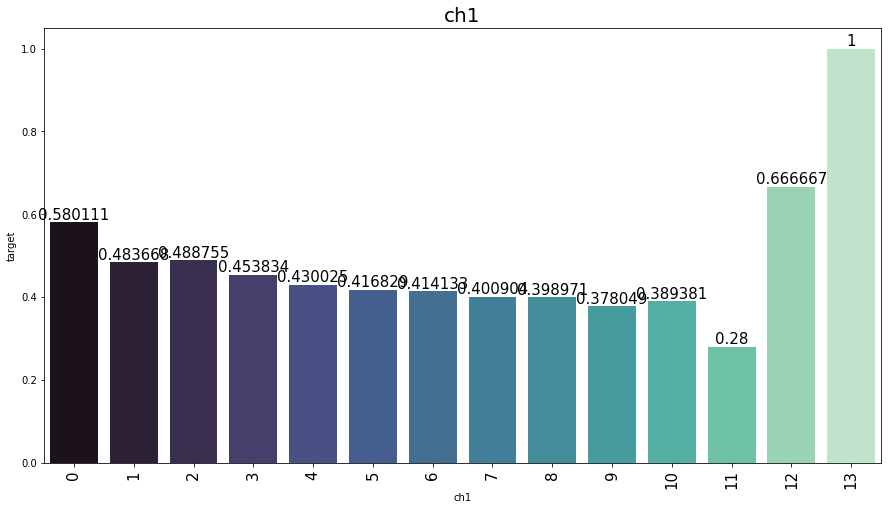

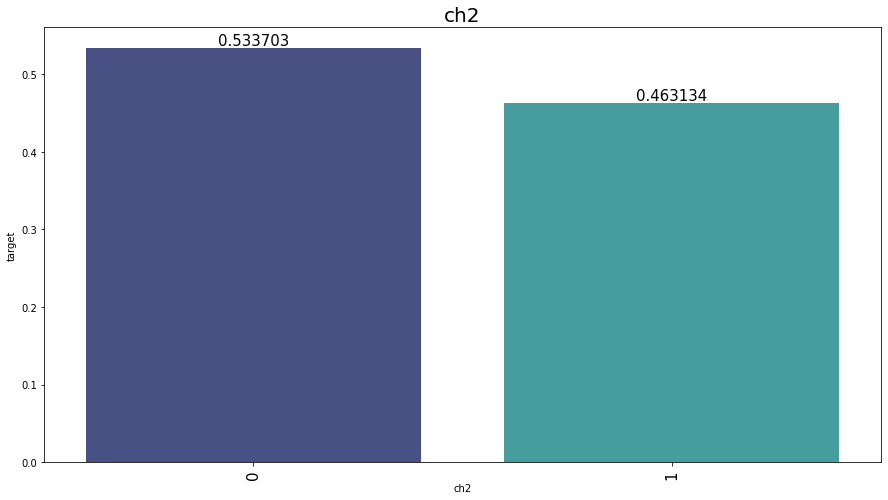

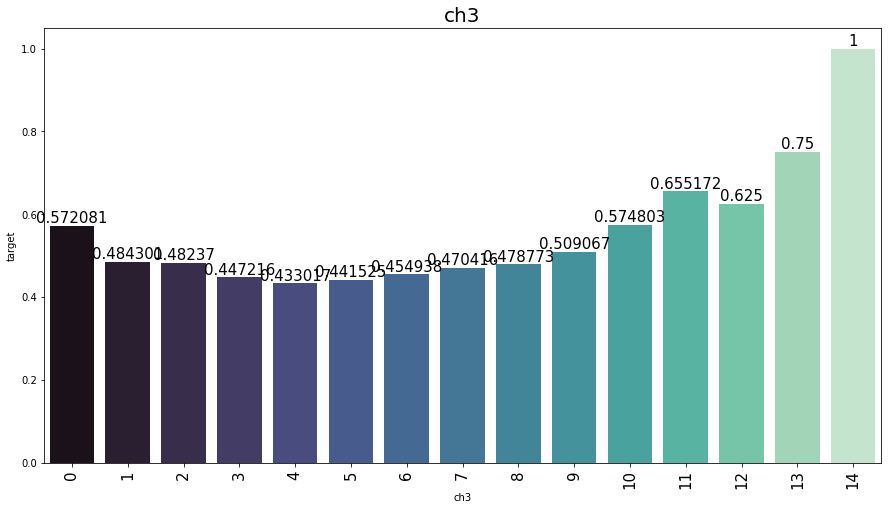

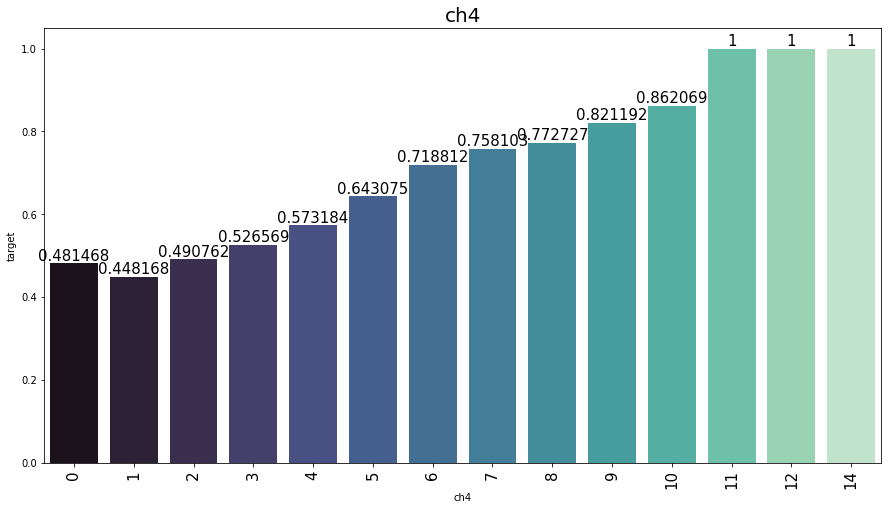

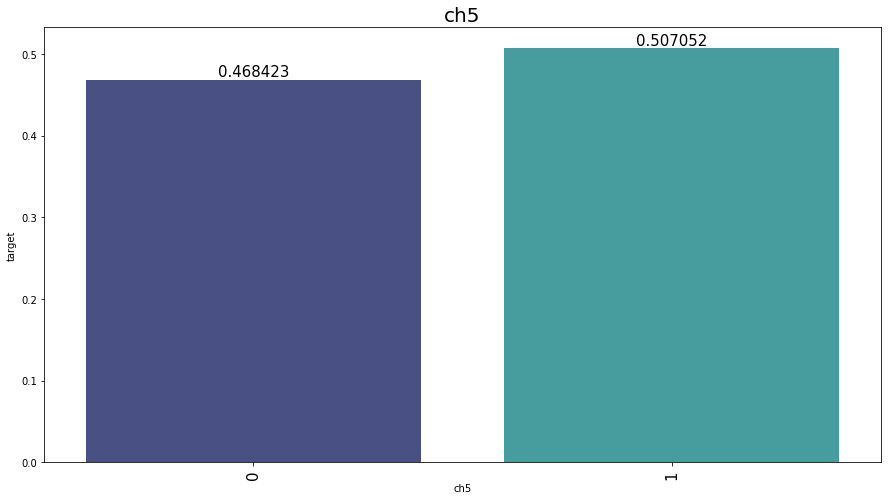

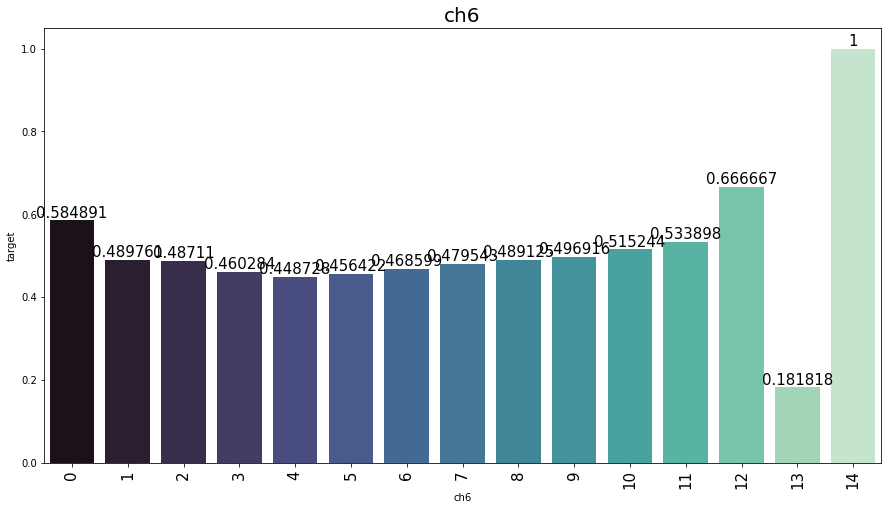

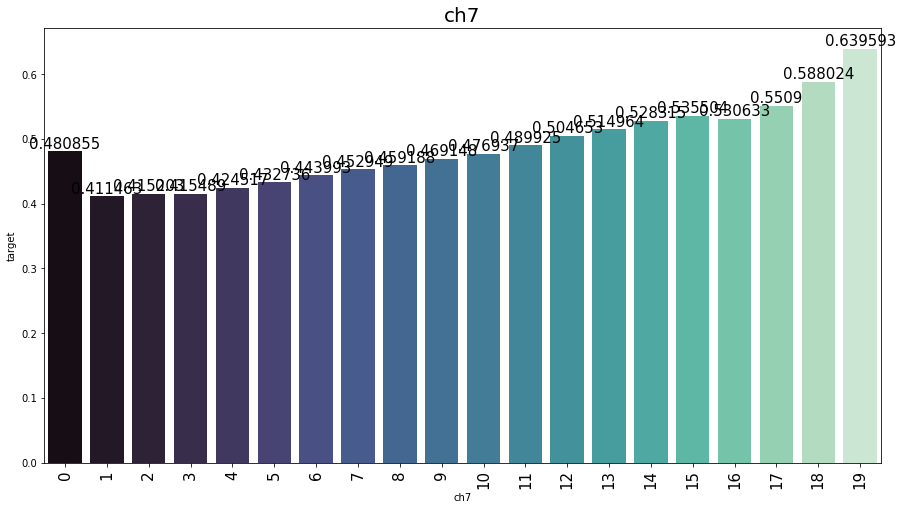

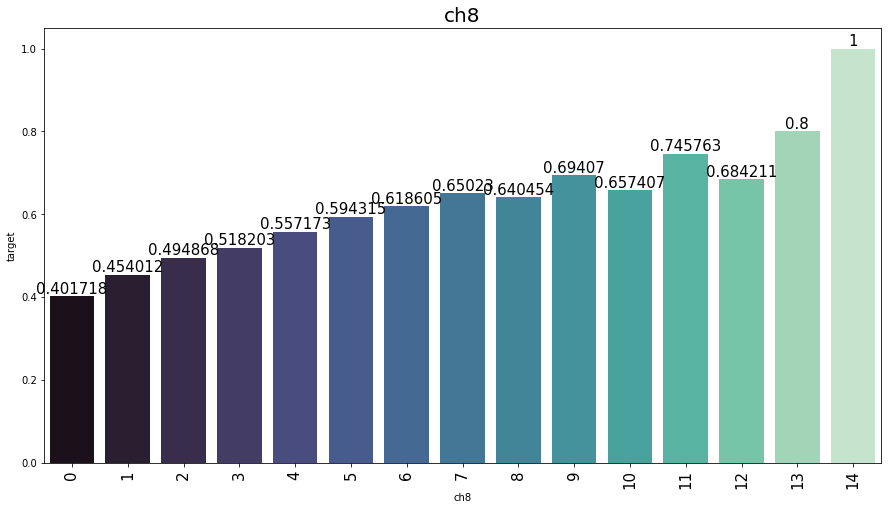

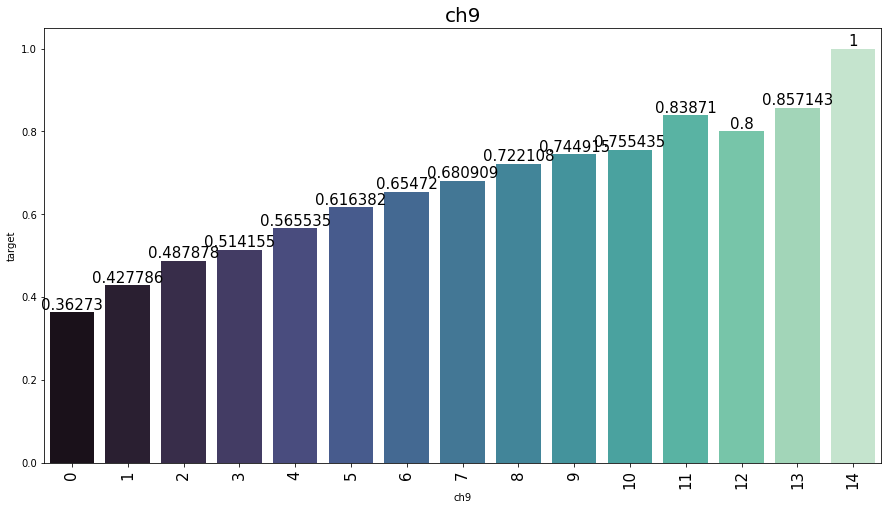

In [72]:
for i in range(10):
    train['ch'+str(i)] = train['f_27'].str[i].apply(ord) - ord('A')
    
    stats = train.groupby('ch'+str(i), as_index=False)['target'].mean()
    fig, ax = plt.subplots(figsize=(15, 8))

    sns.barplot(data=stats, ax=ax, x='ch'+str(i), y="target",  palette="mako",ci=None)
    plt.xticks(rotation=90, fontsize=15) 
    ax.bar_label(ax.containers[0], fontsize=15)
    plt.title('ch'+str(i), fontsize=20)

# train LGBMClassifier

In [81]:
train = pd.read_csv('train.csv')
drop_columns = ['f_27', 'id']


X = train.drop('target', axis=1)
y = train['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)
clf = lgbm.LGBMClassifier(n_estimators=500, random_state=0, verbose=1)
clf.fit(X_train.drop(drop_columns, axis=1), y_train)
y_pred = clf.predict_proba(X_test.drop(drop_columns, axis=1))[:, 1]
roc_auc_score(y_test, y_pred)

[LightGBM] [Info] Number of positive: 394055, number of negative: 415945
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4250
[LightGBM] [Info] Number of data points in the train set: 810000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486488 -> initscore=-0.054063
[LightGBM] [Info] Start training from score -0.054063


0.9224458202700333

In [82]:
# increase number of estimators
train = pd.read_csv('train.csv')
drop_columns = ['f_27', 'id']


X = train.drop('target', axis=1)
y = train['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)
clf = lgbm.LGBMClassifier(n_estimators=5000, random_state=0, verbose=1)
clf.fit(X_train.drop(drop_columns, axis=1), y_train)
y_pred = clf.predict_proba(X_test.drop(drop_columns, axis=1))[:, 1]
roc_auc_score(y_test, y_pred)

[LightGBM] [Info] Number of positive: 394055, number of negative: 415945
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4250
[LightGBM] [Info] Number of data points in the train set: 810000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486488 -> initscore=-0.054063
[LightGBM] [Info] Start training from score -0.054063


0.9379438757232107

In [83]:
# add f_27 features
train = pd.read_csv('train.csv')
drop_columns = ['f_27', 'id']

train['char_unique_num'] = train['f_27'].apply(set).apply(len)
test['char_unique_num'] = test['f_27'].apply(set).apply(len)

for i in range(10):
    train['ch'+str(i)] = train['f_27'].str[i].apply(ord) - ord('A')
    test['ch'+str(i)] = test['f_27'].str[i].apply(ord) - ord('A')
    
X = train.drop('target', axis=1)
y = train['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)
clf = lgbm.LGBMClassifier(n_estimators=5000, random_state=0, verbose=1)
clf.fit(X_train.drop(drop_columns, axis=1), y_train)
y_pred = clf.predict_proba(X_test.drop(drop_columns, axis=1))[:, 1]
roc_auc_score(y_test, y_pred)

[LightGBM] [Info] Number of positive: 394055, number of negative: 415945
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4365
[LightGBM] [Info] Number of data points in the train set: 810000, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486488 -> initscore=-0.054063
[LightGBM] [Info] Start training from score -0.054063


0.9911803628595676

In [ ]:
submit = sample_submission.copy()
submit['target'] = clf.predict_proba(test.drop(drop_columns, axis=1))[:, 1]
submit.to_csv('submission_03.csv', index=False)

Gives 0.99170 on leader board

# SHAP

In [123]:
import copy

In [113]:
X_sample = X_test.sample(5000).drop(drop_columns, axis=1)

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_sample)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


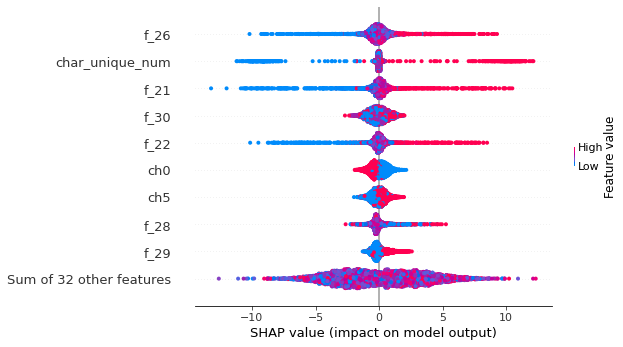

In [124]:
shap_values1 = explainer(X_sample)
shap_values2 = copy.deepcopy(shap_values1)
shap_values2.values = shap_values2.values[:,:,1]
shap_values2.base_values = shap_values2.base_values[:,1]

shap.plots.beeswarm(shap_values2)

Features f_26, f_21 and char_yunique_num have largest impact on model

In [126]:
#Get SHAP interaction values. Beware it is time consuming to calculate the interaction values.
shap_interaction = explainer.shap_interaction_values(X_sample)
print(np.shape(shap_interaction))

(5000, 41, 41)


## Absolute mean plot

Individual contribution matrices allows us to explain individual model predictions at local level. But what if we want to explain how the model makes predictions at a global level? To do this we can aggregate the values in the contribution matrices by taking the absolute mean. Presenting the results in a heatmap can be effective to highlight important main effects and interaction effects.

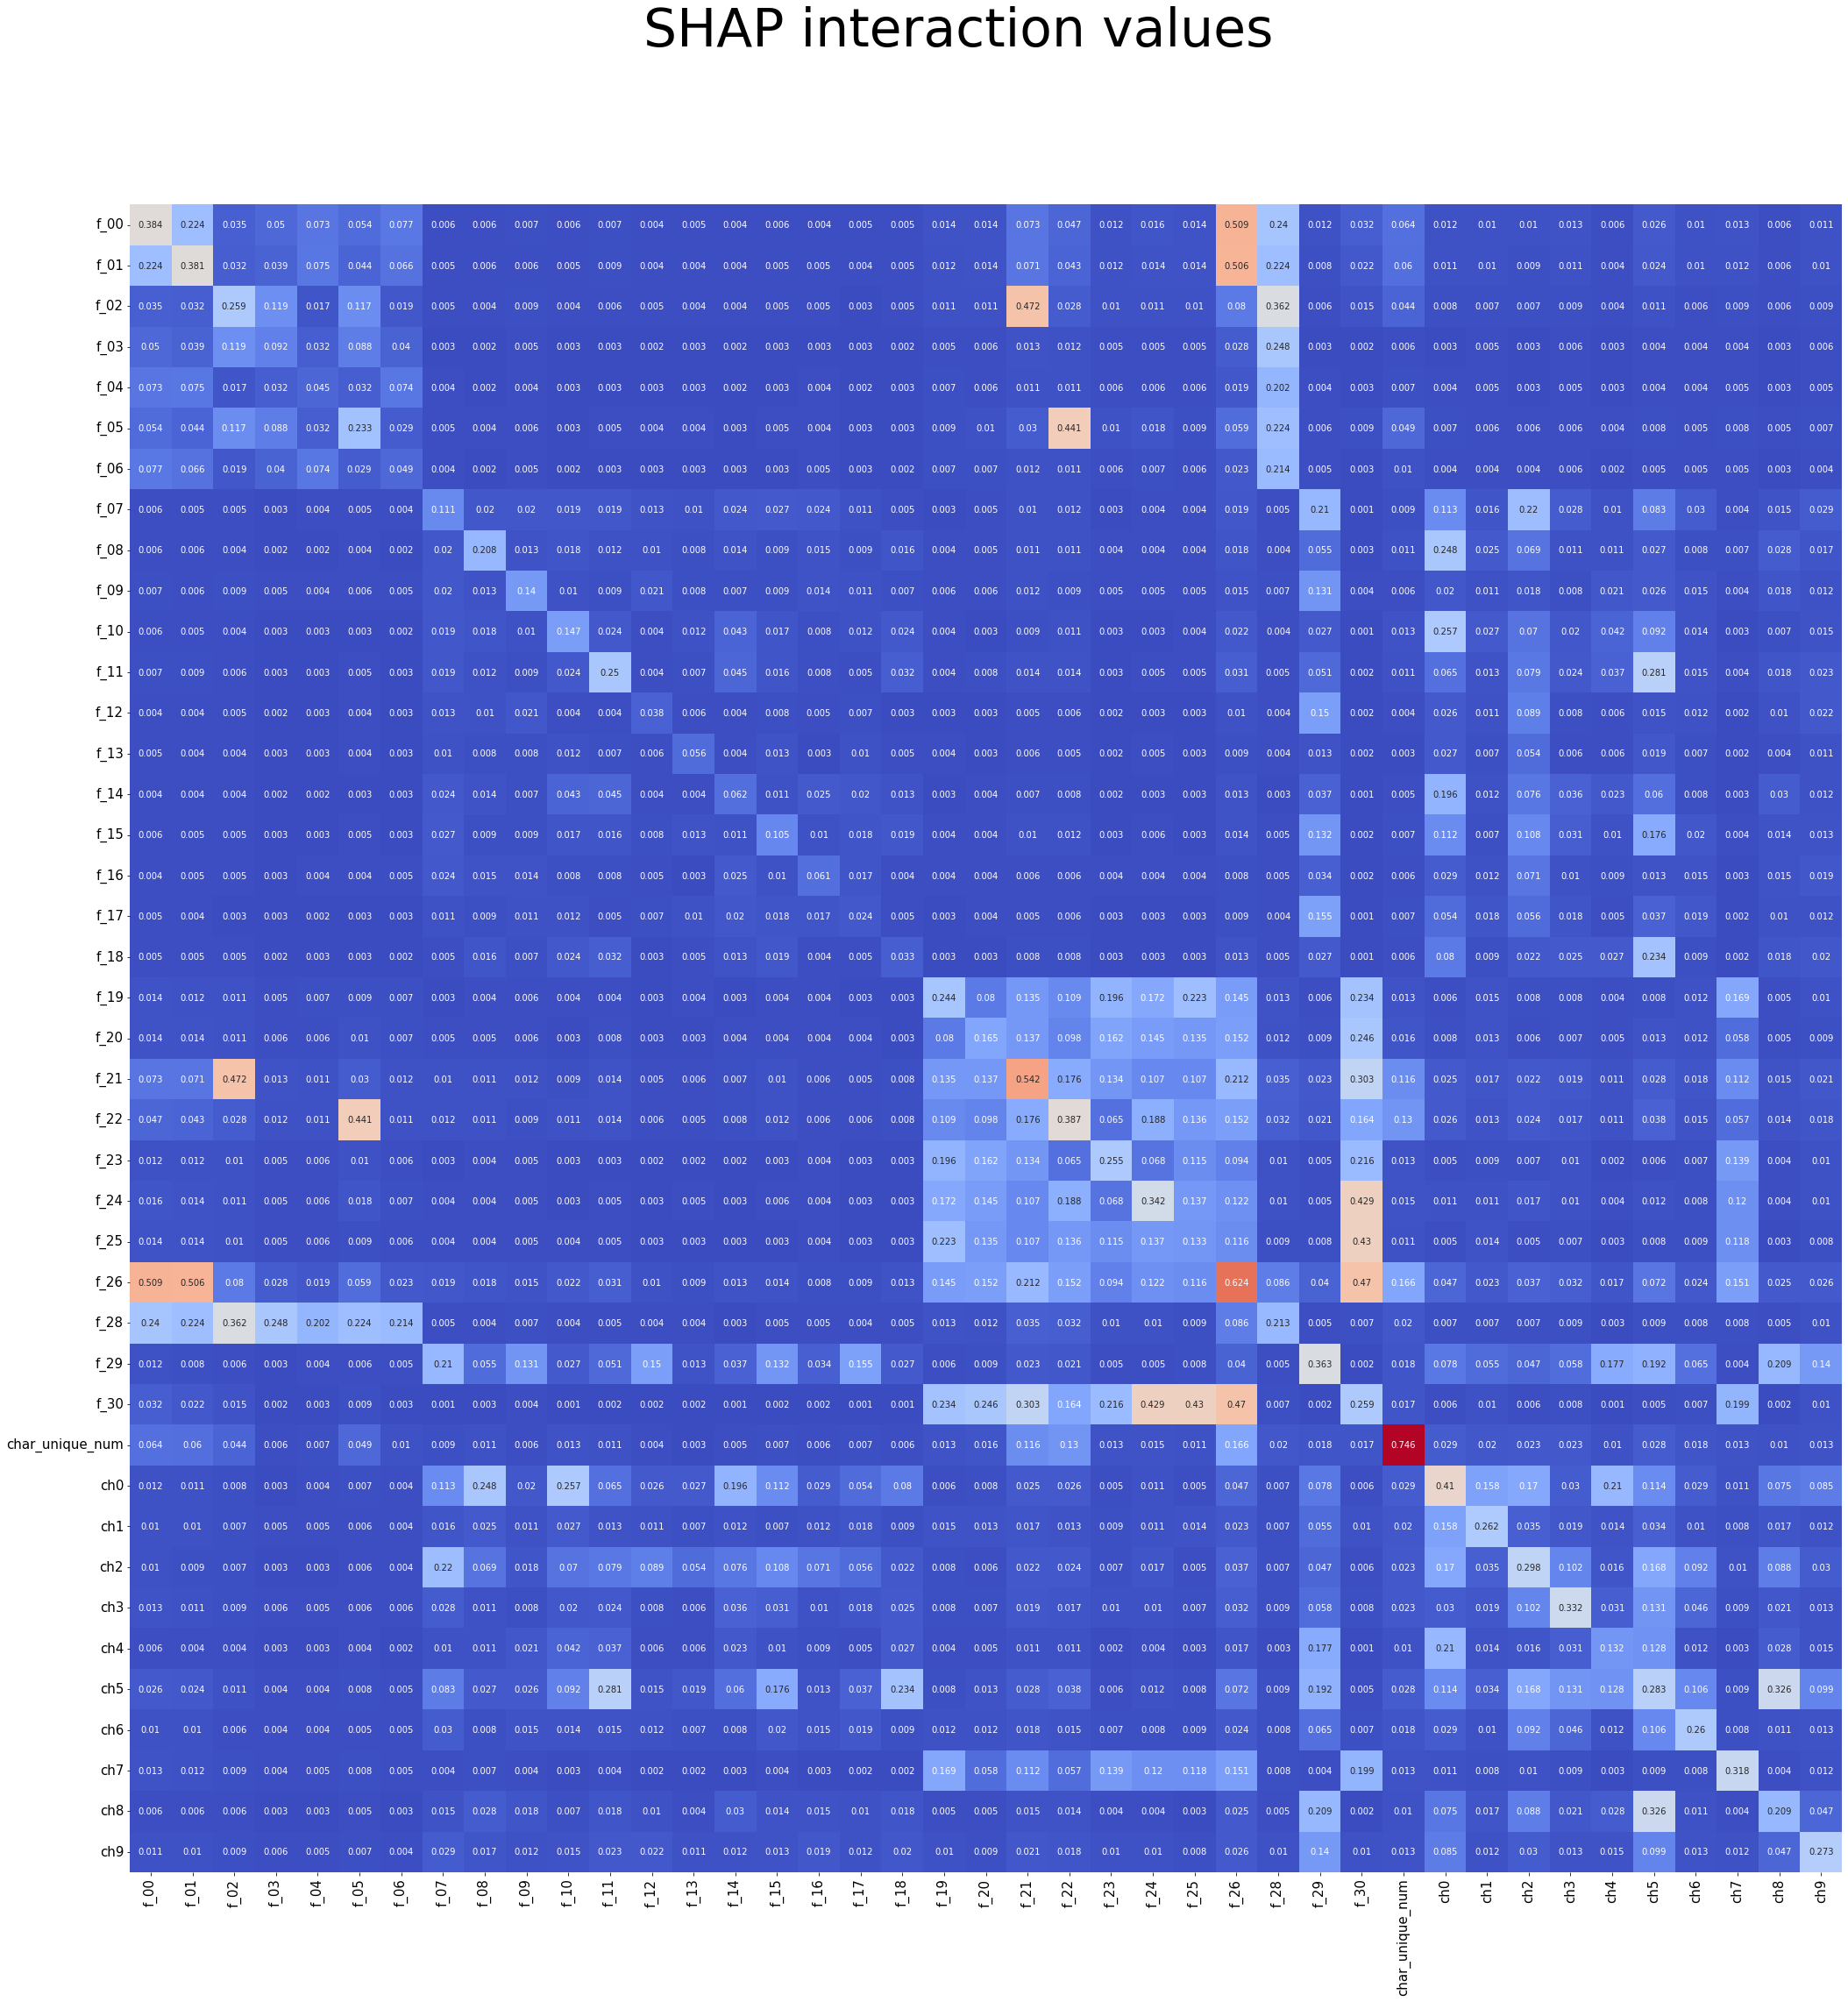

In [134]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap, index=X_sample.columns, columns=X_sample.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2, inplace=True)

# display 
fig = plt.figure(figsize=(35, 35))
ax = fig.add_subplot()
sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=False, ax=ax, )
ax.tick_params(axis='x', labelsize=15, rotation=90)
ax.tick_params(axis='y', labelsize=15)

plt.suptitle("SHAP interaction values", fontsize=60, y=0.97)
plt.yticks(rotation=0) 
plt.show()

In [149]:
s = df.unstack().reset_index()
s[s['level_0'] <= s['level_1']].sort_values(0, ascending=False).head(10)

level_0          level_1         0
1260  char_unique_num  char_unique_num  0.745852
1092             f_26             f_26  0.624359
882              f_21             f_21  0.541698
26               f_00             f_26  0.508656
67               f_01             f_26  0.506358
103              f_02             f_21  0.472460
1095             f_26             f_30  0.469979
227              f_05             f_22  0.441017
1054             f_25             f_30  0.430497
1013             f_24             f_30  0.429270

There is great effect of features char_unique_num, f_26 and f_21 which we saw earlier.
Also there is interactions effect for f_00 + f_26, f_01 + f_26 and f_02 + f_21

<AxesSubplot:xlabel='f_02', ylabel='f_21'>

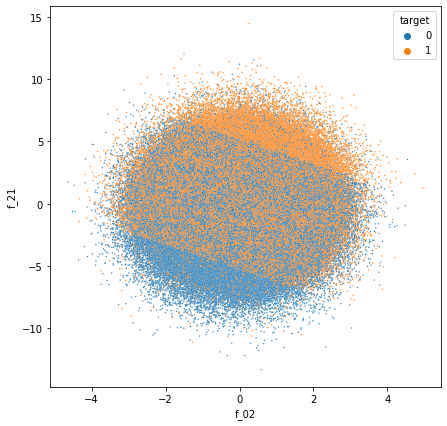

In [159]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x='f_02', y='f_21', data=train, hue="target",  s=2)


In [160]:
for df in [train, test]:
    df['f_02_21'] = df.f_21 + df.f_02
    df['f_00_01_26'] = df.f_00 + df.f_01 + df.f_26

In [163]:
train = pd.read_csv('train.csv')
train = pd.read_csv('train.csv')

drop_columns = ['f_27', 'id']

train['char_unique_num'] = train['f_27'].apply(set).apply(len)
test['char_unique_num'] = test['f_27'].apply(set).apply(len)

for i in range(10):
    train['ch'+str(i)] = train['f_27'].str[i].apply(ord) - ord('A')
    test['ch'+str(i)] = test['f_27'].str[i].apply(ord) - ord('A')
    
for df in [train, test]:
    df['f_02_21'] = df.f_21 + df.f_02
    df['f_00_01_26'] = df.f_00 + df.f_01 + df.f_26
    
X = train.drop('target', axis=1)
y = train['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)
clf = lgbm.LGBMClassifier(n_estimators=5000, random_state=0, verbose=1)
clf.fit(X_train.drop(drop_columns, axis=1), y_train)
y_pred = clf.predict_proba(X_test.drop(drop_columns, axis=1))[:, 1]
roc_auc_score(y_test, y_pred)

[LightGBM] [Info] Number of positive: 394055, number of negative: 415945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4875
[LightGBM] [Info] Number of data points in the train set: 810000, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486488 -> initscore=-0.054063
[LightGBM] [Info] Start training from score -0.054063


0.9952028254958697

In [171]:
submit = sample_submission.copy()
submit['target'] = clf.predict_proba(test.drop(drop_columns, axis=1))[:, 1]
submit.to_csv('submission_04.csv', index=False)

#Score: 0.99527

In [169]:
test

(700000, 48)